# Silid Pod Campanian Ignimbrite Sites

This notebook fetches Campanian Ignimbrite sites using a SPARQL query from a solid pod.

## Define SPARQL query service

In [232]:
from SPARQLWrapper import SPARQLWrapper, TURTLE
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx  # For adding OpenStreetMap basemaps
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np

# Function to query Solid Pod and retrieve data in TURTLE format
def querySolidPod(sparql_endpoint, query):
    sparql = SPARQLWrapper(sparql_endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(TURTLE)  # Request Turtle format
    results = sparql.query().convert()
    return results

## Define the SPARQL Query

In [233]:
# SPARQL Query
solid_pod_query = """
SELECT ?item ?geo ?label ?ref ?spatialType {
 ?item a <http://fuzzy-sl.squirrel.link/ontology/Site> .
 ?item rdfs:label ?label.
 ?item <http://fuzzy-sl.squirrel.link/ontology/hasReference> ?ref .
 ?item <http://fuzzy-sl.squirrel.link/ontology/spatialType> ?spatialType .
 ?item <http://www.opengis.net/ont/geosparql#hasGeometry> ?item_geom .
 ?item_geom <http://www.opengis.net/ont/geosparql#asWKT> ?geo .
}
"""

## Fetch Data and Convert to DataFrame

In [234]:
sparql_endpoint = "https://fuzzy-sl.solidweb.org/campanian-ignimbrite-geo/ci_full.ttl"

# Query the endpoint
turtle_data = querySolidPod(sparql_endpoint, solid_pod_query)

# Parse Turtle data with rdflib
g = Graph()
g.parse(data=turtle_data, format="turtle")

# Extract namespaces
site_ns = Namespace("http://fuzzy-sl.squirrel.link/ontology/")
gs = Namespace("http://www.opengis.net/ont/geosparql#")

# Run the SPARQL query against the loaded Turtle data
results = g.query(solid_pod_query)

# Process the Results into a DataFrame
data = []
for row in results:
    spatial_type = str(row.spatialType).replace("http://fuzzy-sl.squirrel.link/ontology/", "")
    geo_str = str(row.geo)
    if geo_str.find("POINT(") != -1:
        geo_str = geo_str.replace("<http://www.opengis.net/def/crs/EPSG/0/4326>", "").replace("POINT(", "").replace(")", "")
    else:
        geo_str = geo_str.replace("<http://www.opengis.net/def/crs/EPSG/0/4326>", "")
        geo_str = geo_str.replace(")", "")
        geo_str = geo_str.replace(" POINT (", "")
    
    lon, lat = map(float, geo_str.split())
    
    data.append({
        "spatialType": spatial_type,
        "latitude": lat,
        "longitude": lon,
    })

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)
df

c:\Users\flori\AppData\Local\Programs\Python\Python310\lib\site-packages\SPARQLWrapper\Wrapper.py:778: RuntimeWarning: Sending Accept header '*/*' because unexpected returned format 'turtle' in a 'SELECT' SPARQL query form
  warnings.warn(


,spatialType,latitude,longitude
0,Sink,40.9489,14.3624
1,UnknownCategory,40.9285,14.6983
2,InhabitedPlace,40.7119,14.7680
3,InhabitedPlace,40.6993,14.5259
4,Cave,40.4956,15.2092
...,...,...,...
98,UnknownCategory,44.9032,20.2802
99,UnknownCategory,44.2462,27.9347
100,UnknownCategory,44.2462,27.9347
101,Lake,40.9167,21.0000


## Visualise the Data in a bar chart

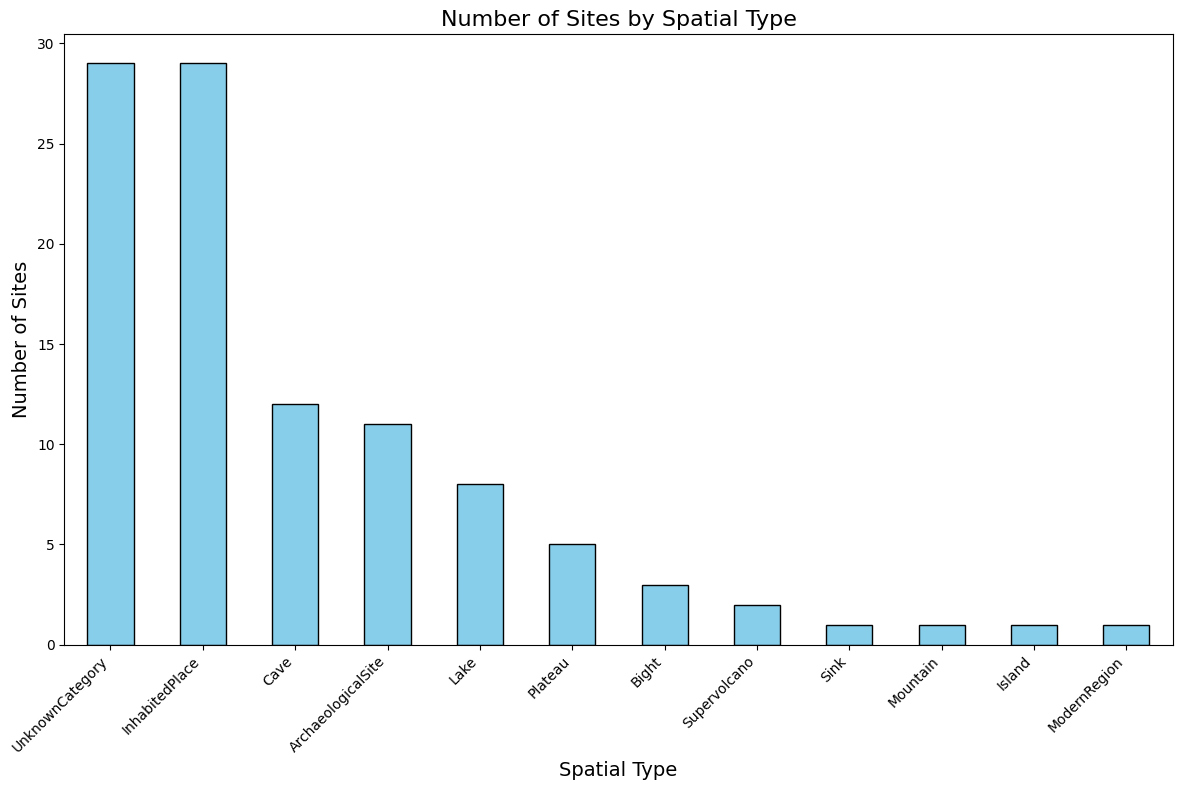

In [235]:

# Check if DataFrame is populated
if not df.empty and 'spatialType' in df:
    # Plot 1: Number of Sites by Spatial Type
    plt.figure(figsize=(12, 8))
    df['spatialType'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Number of Sites by Spatial Type", fontsize=16)
    plt.xlabel("Spatial Type", fontsize=14)
    plt.ylabel("Number of Sites", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No data retrieved or 'spatialType' column is missing.")

## Visualise the Data in a map

In [ ]:
# Check if DataFrame is populated
if df.empty:
    print("No data retrieved from the query.")
else:
    # Filter rows with valid coordinates
    df_with_coords = df.dropna(subset=['latitude', 'longitude'])

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df_with_coords,
        geometry=[Point(xy) for xy in zip(df_with_coords['longitude'], df_with_coords['latitude'])],
        crs="EPSG:4326"
    )

    # Convert to Web Mercator for OSM basemap
    gdf_mercator = gdf.to_crs(epsg=3857)

    # Plot points on the map
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf_mercator.plot(ax=ax, color='red', markersize=50, alpha=0.7, label="CI sites")
    
    # Add OSM basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    ax.set_axis_off()
    plt.title("Map of CI sites in Europe")
    plt.legend()
    plt.show()